In [ ]:
###########################################
# This file contains the following:
# 1. Linear Transformer Model
# 2. Function for clipping gradient
# 3. Function for generating random data
###########################################


import torch
from torch import nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definition of a single linear attention unit for linear-regression data
# P is the value matrix
# Q is the product of key,query matrices
# the dimensions of the input are
# B: batch-size of prompts
# N: context length (excluding query)
# d: covariate dimension
# P,Q are d x d matrices
# Z is a B x (N+1) + (d+1) matrix
# Output is also B x (N+1) + (d+1)

# For linear attention, activation = None
# For standard attention, activation(x) = torch.nn.functional.softmax(x, dim = 2)
# For ReLU attention, activation(x) = torch.nn.relu(x)
def attention(P,Q,Z, activation = None):
    B= Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    P_full =  torch.cat([P,torch.zeros(1,d).to(device)],dim=0)
    P_full =  torch.cat([P_full,torch.zeros(d+1,1).to(device)],dim=1)
    P_full[d,d] = 1
    Q_full = torch.cat([Q, torch.zeros(1,d).to(device)],dim=0)
    Q_full = torch.cat([Q_full, torch.zeros(d+1,1).to(device)],dim=1)
    A = torch.eye(N+1).to(device)
    A[N,N] = 0
    Attn = torch.einsum('BNi, ij, BMj -> BNM', (Z,Q_full,Z))
    if activation is not None:
        Attn = activation(Attn)
    key = torch.einsum('ij, BNj -> BNi', (P_full,Z))
    Output = torch.einsum('BNM,ML, BLi -> BNi', (Attn,A,key))
    return Output /N


# The Linear Transformer module
# n_layer denotes the number of layers
# n_head denotes the number of heads. In most of our experiments, n_head = 1
# d denotes the dimension of covariates
# var denotes the variance of initialization. It needs to be sufficiently small, but exact value is not important
# allparam: contains all the parameters, has dimension n_layer x n_head x 2 x d x d
# For example
# - P matrix at layer i, head j is allparam[i,j,0,:,:]
# - Q matrix at layer i, head j is allparam[i,j,1,:,:]
# If run_mode = 0 then training. If run_mode = 1 then in-context learning.
class Transformer_F(nn.Module):
    def __init__(self, n_layer, n_head, N, d, var, run_mode):
        super(Transformer_F, self).__init__()
        self.register_parameter('allparam', torch.nn.Parameter(torch.zeros(n_layer, n_head, 2, d, d)))
        # Initialize gamma with requires_grad=False initially
        self.gamma = nn.Parameter(torch.zeros(n_layer, 1, N + 1, d + 1), requires_grad=False)
        self.alpha = nn.Parameter(torch.ones(n_layer), requires_grad=False)

        with torch.no_grad():
            self.allparam.normal_(0,var)
        self.n_layer = n_layer
        self.n_head = n_head
        self.run_mode = run_mode

    def forward(self, Z):
        R = torch.zeros_like(Z)
        # Toggle gamma training based on run_mode
        self.gamma.requires_grad = (self.run_mode == 1)
        self.alpha.requires_grad = (self.run_mode == 1)
        # Extract B, N and d values
        B, N, d = Z.shape[0], Z.shape[1]-1, Z.shape[2]-1

        # Enforce the sparsity condition before processing
        # self.zero_p()

        for i in range(self.n_layer):
            Zi = Z
            attention_sum = torch.zeros_like(Z)
            # the forwarad map of each layer is given by F(Z) = Z + attention(Z)
            for j in range(self.n_head):
                Pij = self.allparam[i,j,0,:,:]
                Qij = self.allparam[i,j,1,:,:]
                attention_sum = attention_sum + attention(Pij,Qij,Zi)

            if self.run_mode == 0:
                R = attention_sum
            else:
                R = R * self.gamma[i] + attention_sum

            Z = Zi + R * self.alpha[i]

        return Z

    #enforces top-left-dxd-block sparsity on p
    def zero_p(self):
        for i in range(self.n_layer):
            for j in range(self.n_head):
                with torch.no_grad():
                    self.allparam[i,j,0,:,:].zero_()

# evaluate the loss of model, given data (Z,y)
def in_context_loss(model, Z, y):
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    output = model(Z)
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean()
    return loss

# generate random data for linear regression
# mode: distribution of samples to generate. Currently supports 'normal', 'gamma', 'sphere'
# N: number of context examples
# d: dimension of covariates
# For gamma distribution:
# - shape_k: shape parameter of gamma distribution (unused otherwise)
# - scale parameter: hard coded so that when shape_k = 5/2 and d=5, the generated data is standard normal
def generate_data(mode='normal',N=20,d=1,B=1000,shape_k=0.1, U=None, D=None):
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B,1,d).normal_(0, 1).to(device)

    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W= torch.FloatTensor(B, d).normal_(0,1).to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())

    if mode =='sphere':
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
    elif mode == 'gamma':
        # random gamma scaling for X
        gamma_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,N])
        gamma_scales = torch.Tensor(gamma_scales).to(device)
        gamma_scales = gamma_scales.sqrt()
        # random gamma scaling for X_test
        gamma_test_scales = np.random.gamma(shape=shape_k, scale=(10/shape_k)**(0.5), size=[B,1])
        gamma_test_scales = torch.Tensor(gamma_test_scales).to(device)
        gamma_test_scales = gamma_test_scales.sqrt()
        # normalize to unit norm
        X.div_(X.norm(p=2,dim=2)[:,:,None])
        X_test.div_(X_test.norm(p=2,dim=2)[:,:,None])
        # scale by gamma
        X.mul_(gamma_scales[:,:,None])
        X_test.mul_(gamma_test_scales[:,:,None])
    elif mode =='normal':
        assert True
    elif mode == 'relu':
        return generate_data_relu(N=N, d=d, B=B, hidden_dim=d)
    elif mode == 'mlp':
        generate_data_mlp(N=N, d=d, B=B, hidden_dim=d)
    else:
        assert False

    if U is not None:
        X = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))
        X_test = torch.einsum('ij, jk, BNk -> BNi', (U,D,X_test))

    y = torch.einsum('bi,bni->bn', (W, X)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test)).squeeze(1)
    X_comb= torch.cat([X,X_test],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)
    return Z.to(device),y_test.to(device)

def generate_data_inplace(Z, U=None, D=None):


    B = Z.shape[0]
    N = Z.shape[1]-1
    d = Z.shape[2]-1
    X = Z[:,:,0:-1]
    X.normal_(0, 1).to(device)
    W= torch.FloatTensor(B, d).normal_(0,1).to(device)
    if U is not None:
        U = U.to(device)
        D = D.to(device)
        W = torch.mm(W,torch.inverse(D))
        W = torch.mm(W,U.t())
        Z[:,:,0:-1] = torch.einsum('ij, jk, BNk -> BNi', (U,D,X))

    Z[:,:,-1] = torch.einsum('bi,bni->bn', (W, Z[:,:,0:-1])) #y update
    y_test = Z[:,-1,-1].detach().clone()
    Z[:,-1,-1].zero_()
    return Z.to(device),y_test.to(device)

def generate_data_sine(N=10, B=1000):
    # Sample amplitude a and phase p for each task
    a = torch.FloatTensor(B).uniform_(0.1, 5).to(device)
    p = torch.FloatTensor(B).uniform_(0, math.pi).to(device)

    X = torch.FloatTensor(B, N).uniform_(-5, 5).to(device)

    Y = a.unsqueeze(1) * torch.sin(p.unsqueeze(1) + X)

    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)

    return X, Y

def generate_data_relu(mode='normal', N=20, d=1, B=1000, shape_k=0.1, U=None, D=None, hidden_dim=100):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    # Define a 1-hidden layer ReLU network
    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    ).to(device)
    model[0].weight.data.normal_(0, 0.1)
    model[2].weight.data.normal_(0, 0.1)

    # Generate y values using the ReLU network
    y = model(X.view(-1, d)).view(B, N, 1)
    y_test = model(X_test.view(-1, d)).view(B, 1).squeeze(1)

    y_zero = torch.zeros(B, 1, 1).to(device)
    X_comb = torch.cat([X, X_test], dim=1)
    y_comb = torch.cat([y, y_zero], dim=1)
    Z = torch.cat([X_comb, y_comb], dim=2)

    return Z, y_test

def generate_data_mlp(N=20, d=1, B=1000, hidden_dim=100):
    # Generate random input data
    X = torch.FloatTensor(B, N, d).normal_(0, 1).to(device)
    X_test = torch.FloatTensor(B, 1, d).normal_(0, 1).to(device)

    # Additional transformations if mode is 'sphere' or 'gamma' [Similar to the existing generate_data function]

    # Define a 1-hidden layer ReLU network
    model = nn.Sequential(
        nn.Linear(d, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, d)
    ).to(device)
    model[0].weight.data.normal_(0, 1)
    model[2].weight.data.normal_(0, 1)

    X_MLP = model(X.view(-1, d)).view(B, N, d)
    X_test_MLP = model(X_test.view(-1, d)).view(B, 1, d)

    W = torch.FloatTensor(B, d).normal_(0,1).to(device)
    y = torch.einsum('bi,bni->bn', (W, X_MLP)).unsqueeze(2)
    y_zero = torch.zeros(B,1,1).to(device)
    y_test = torch.einsum('bi,bni->bn', (W, X_test_MLP)).squeeze(1)
    X_comb= torch.cat([X_MLP,X_test_MLP],dim=1)
    y_comb= torch.cat([y,y_zero],dim=1)
    Z= torch.cat([X_comb,y_comb],dim=2)

    return Z, y_test

In [ ]:
import linear_transformer

In [ ]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np
import math

##############################################################################################################
# Trains a linear Transformer with 1,2,3,4 layers
# Plots the test loss of trained Transformer against 1,2,3,4 steps of gradient descent (with and without preconditioning)
##############################################################################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
cur_dir = 'log'
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/rotation.log', "a", 1)
#sys.stdout = f

In [ ]:
# Set up problem parameters

lr = 0.01
clip_r = 0.01
alg = 'adam'
mode = 'normal'

n_layer = 4  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 1  # 1-headed attention
B = 1000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 10  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        for l in range(grad_all.shape[0]):
            for h in range(grad_all.shape[1]):
                for t in range(grad_all.shape[2]):
                    norm_p = grad_all[l,h,t,:,:].norm().item()
                    if norm_p > clip_r:
                        grad_all[l,h,t,:,:].mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

#format for saving run data
filename_format = '/variable_L_hist_{}_{}_{}.pth'
n_layers = [1,2,3,4]  # number of layers of transformer
seeds=[0,1,2,3,4]
keys = []
for s in seeds:
    for n_layer in n_layers:
        keys.append((s,n_layer,))

In [ ]:
import torch
import numpy as np
import time

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for key in keys:
    sd = key[0]
    n_layer = key[1]
    filename = cur_dir + filename_format.format(n_layer, N, sd)
    print(key)

    prob_seed = sd
    opt_seed = sd

    hist = []

    # Set seed and initialize model
    torch.manual_seed(opt_seed)
    model = Transformer_F(n_layer, 1, N, d, var, 0)
    model.to(device)  # Move the model to the appropriate device

    # Initialize algorithm. Important: set beta = 0.9 for adam, 0.999 is very slow
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.99, 0.9), weight_decay=0)

    # Set seed
    # Sample random rotation matrix
    # Initialize initial training batch
    np.random.seed(prob_seed)
    torch.manual_seed(prob_seed)
    gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)  # Ensure tensor is on the correct device
    U = torch.linalg.svd(gaus)[0].to(device)
    D = torch.diag(torch.FloatTensor([1, 1, 1, 1, 1])).to(device)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    for t in range(max_iters):
        if t % 4000 == 0 and t > 1:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.5
        if t % 100 == 0:
            Z, y = generate_data_inplace(Z, U=U, D=D)

        start = time.time()

        # Save model parameters
        if t % stride == 0:
            hist.append(model.allparam.clone().detach())

        loss = in_context_loss(model, Z, y)

        # Compute gradient and take a step
        loss.backward()
        norms = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        optimizer.zero_grad()

        end = time.time()

        if t % 100 == 0 or t < 5:
            print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t, loss.item(), end-start, norms))

    torch.save({'hist': hist, 'U': U, 'D': D}, filename)

(0, 1)
iter 0 | Loss: 4.824707508087158  time: 0.01625537872314453  gradnorm: 4.498101711273193
iter 1 | Loss: 4.690598964691162  time: 0.008856534957885742  gradnorm: 4.399909496307373
iter 2 | Loss: 4.5636796951293945  time: 0.008956432342529297  gradnorm: 4.304471492767334
iter 3 | Loss: 4.443755626678467  time: 0.00833749771118164  gradnorm: 4.211678981781006
iter 4 | Loss: 4.3305487632751465  time: 0.009111166000366211  gradnorm: 4.121557712554932
(0, 2)
iter 0 | Loss: 4.824171543121338  time: 0.01845574378967285  gradnorm: 4.497699737548828
iter 1 | Loss: 4.5657525062561035  time: 0.017023801803588867  gradnorm: 4.236125946044922
iter 2 | Loss: 4.339327335357666  time: 0.016095399856567383  gradnorm: 4.011485576629639
iter 3 | Loss: 4.139827251434326  time: 0.016371488571166992  gradnorm: 3.8167612552642822
iter 4 | Loss: 3.9615252017974854  time: 0.016012907028198242  gradnorm: 3.6442480087280273
(0, 3)
iter 0 | Loss: 4.8241095542907715  time: 0.02756333351135254  gradnorm: 4.49

In [ ]:
import torch
import linear_transformer
import numpy as np
import torch.optim as optim

B = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LFOM update function with Hadamard product (batch processing)
def do_lfom(Z, numstep, gamma):
    N = Z.shape[1] - 1  # sequence_length - 1
    X = Z[:, 0:N-1, 0:5]  # [batch_size, N-1, 5]
    Y = Z[:, 0:N-1, 5]    # [batch_size, N-1]
    w = torch.zeros((X.shape[0], X.shape[2]), requires_grad=True).to(device)  # [batch_size, 5]

    grads = []

    for k in range(numstep):
        # Compute gradient for the current iterate
        Xw = torch.einsum('bij,bj->bi', X, w)  # [batch_size, N-1]
        residuals = Xw - Y  # [batch_size, N-1]
        grad = torch.einsum('bij,bi->bj', X, residuals)  # [batch_size, 5]
        grads.append(grad)

        # Apply LFOM update using learned gamma matrices
        w_update = torch.zeros_like(w)
        for i in range(len(grads)):
            gamma_i = gamma[i]  # [5]
            w_update += grads[i] * gamma_i  # Element-wise product

        w = w - w_update  # Update the weights

    return w  # [batch_size, 5]

# Evaluation function for batch instances
def eval_w_instance(Z, Ytest, w):
    N = Z.shape[1] - 1
    Xtest = Z[:, N, 0:5]  # [batch_size, 5]
    prediction = torch.einsum('bi,bi->b', w, Xtest)  # [batch_size]
    loss = (Ytest - prediction) ** 2  # [batch_size]
    return loss, prediction

# Define seeds and layers
seeds = [0]  # Example seeds
n_layers = [1, 2, 3, 4]  # Example number of layers

# Initialize loss matrix
gd_loss_matrixB10 = torch.zeros(len(seeds), len(n_layers))

# Main loop to find the best eta and evaluate performance
for n_idx, n_layer in enumerate(n_layers):
    sd = 1
    numstep = n_layer

    # Generate U and D matrices (placeholder)
    np.random.seed(sd)
    torch.manual_seed(sd)
    gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
    U = torch.linalg.svd(gaus)[0].to(device)
    D = torch.diag(torch.FloatTensor([1, 1, 1, 1, 1])).to(device)

    # Generate training data
    np.random.seed(999)
    torch.manual_seed(999)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    # Initialize gamma matrices as learnable parameters
    gamma = [torch.zeros(5, requires_grad=True).to(device) for _ in range(numstep)]
    optimizer = optim.Adam(gamma, lr=0.01)

    num_epochs = 1000

    # Training phase
    for k in range(num_epochs):
        optimizer.zero_grad()
        w = do_lfom(Z, numstep, gamma)
        gd_loss, gd_pred = eval_w_instance(Z, y, w)
        total_loss = gd_loss.sum()
        total_loss.backward()
        optimizer.step()
        mean_loss = total_loss / Z.shape[0]
        #print(f'n_layer: {n_layer}, loss: {mean_loss.item()}')

    # Evaluation phase (without parameter updates)
    for idx, sd in enumerate(seeds):
        torch.manual_seed(sd)
        Z_test, y_test = Z, y
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        with torch.no_grad():
            w = do_lfom(Z_test, numstep, gamma)
            gd_loss, gd_pred = eval_w_instance(Z_test, y_test, w)
            total_loss = gd_loss.sum()

        mean_loss = total_loss / Z.shape[0]
        gd_loss_matrixB10[idx, n_idx] = mean_loss.item()

# Compute mean and std of log test loss for plotting
gd_loss_meanB10 = gd_loss_matrixB10.log().mean(dim=0)
gd_loss_stdB10 = gd_loss_matrixB10.log().std(dim=0)

# Print the results
print('Mean log test loss:', gd_loss_meanB10)
print('Std of log test loss:', gd_loss_stdB10)

Mean log test loss: tensor([ -1.53,  -3.52, -23.19, -26.50])
Std of log test loss: tensor([nan, nan, nan, nan])


<ipython-input-7-12c1f23f549b>:105: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  gd_loss_stdB10 = gd_loss_matrixB10.log().std(dim=0)


In [ ]:
import torch
import linear_transformer
import numpy as np
import torch.optim as optim

B = 50

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LFOM update function with Hadamard product (batch processing)
def do_lfom(Z, numstep, gamma):
    N = Z.shape[1] - 1  # sequence_length - 1
    X = Z[:, 0:N-1, 0:5]  # [batch_size, N-1, 5]
    Y = Z[:, 0:N-1, 5]    # [batch_size, N-1]
    w = torch.zeros((X.shape[0], X.shape[2]), requires_grad=True).to(device)  # [batch_size, 5]

    grads = []

    for k in range(numstep):
        # Compute gradient for the current iterate
        Xw = torch.einsum('bij,bj->bi', X, w)  # [batch_size, N-1]
        residuals = Xw - Y  # [batch_size, N-1]
        grad = torch.einsum('bij,bi->bj', X, residuals)  # [batch_size, 5]
        grads.append(grad)

        # Apply LFOM update using learned gamma matrices
        w_update = torch.zeros_like(w)
        for i in range(len(grads)):
            gamma_i = gamma[i]  # [5]
            w_update += grads[i] * gamma_i  # Element-wise product

        w = w - w_update  # Update the weights

    return w  # [batch_size, 5]

# Evaluation function for batch instances
def eval_w_instance(Z, Ytest, w):
    N = Z.shape[1] - 1
    Xtest = Z[:, N, 0:5]  # [batch_size, 5]
    prediction = torch.einsum('bi,bi->b', w, Xtest)  # [batch_size]
    loss = (Ytest - prediction) ** 2  # [batch_size]
    return loss, prediction

# Define seeds and layers
seeds = [0]  # Example seeds
n_layers = [1, 2, 3, 4]  # Example number of layers

# Initialize loss matrix
gd_loss_matrixB50 = torch.zeros(len(seeds), len(n_layers))

# Main loop to find the best eta and evaluate performance
for n_idx, n_layer in enumerate(n_layers):
    sd = 1
    numstep = n_layer

    # Generate U and D matrices (placeholder)
    np.random.seed(sd)
    torch.manual_seed(sd)
    gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
    U = torch.linalg.svd(gaus)[0].to(device)
    D = torch.diag(torch.FloatTensor([1, 1, 1, 1, 1])).to(device)

    # Generate training data
    np.random.seed(999)
    torch.manual_seed(999)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    # Initialize gamma matrices as learnable parameters
    gamma = [torch.zeros(5, requires_grad=True).to(device) for _ in range(numstep)]
    optimizer = optim.Adam(gamma, lr=0.01)

    num_epochs = 5000

    # Training phase
    for k in range(num_epochs):
        optimizer.zero_grad()
        w = do_lfom(Z, numstep, gamma)
        gd_loss, gd_pred = eval_w_instance(Z, y, w)
        total_loss = gd_loss.sum()
        total_loss.backward()
        optimizer.step()
        mean_loss = total_loss / Z.shape[0]
        #print(f'n_layer: {n_layer}, loss: {mean_loss.item()}')

    # Evaluation phase (without parameter updates)
    for idx, sd in enumerate(seeds):
        torch.manual_seed(sd)
        Z_test, y_test = Z, y
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        with torch.no_grad():
            w = do_lfom(Z_test, numstep, gamma)
            gd_loss, gd_pred = eval_w_instance(Z_test, y_test, w)
            total_loss = gd_loss.sum()

        mean_loss = total_loss / Z.shape[0]
        gd_loss_matrixB50[idx, n_idx] = mean_loss.item()

# Compute mean and std of log test loss for plotting
gd_loss_meanB50 = gd_loss_matrixB50.log().mean(dim=0)
gd_loss_stdB50 = gd_loss_matrixB50.log().std(dim=0)

# Print the results
print('Mean log test loss:', gd_loss_meanB50)
print('Std of log test loss:', gd_loss_stdB50)

Mean log test loss: tensor([-0.40, -0.77, -1.23, -1.42])
Std of log test loss: tensor([nan, nan, nan, nan])


<ipython-input-38-b67420bcc357>:105: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  gd_loss_stdB50 = gd_loss_matrixB50.log().std(dim=0)


In [ ]:
import torch
import linear_transformer
import numpy as np
import torch.optim as optim

B = 100

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LFOM update function with Hadamard product (batch processing)
def do_lfom(Z, numstep, gamma):
    N = Z.shape[1] - 1  # sequence_length - 1
    X = Z[:, 0:N-1, 0:5]  # [batch_size, N-1, 5]
    Y = Z[:, 0:N-1, 5]    # [batch_size, N-1]
    w = torch.zeros((X.shape[0], X.shape[2]), requires_grad=True).to(device)  # [batch_size, 5]

    grads = []

    for k in range(numstep):
        # Compute gradient for the current iterate
        Xw = torch.einsum('bij,bj->bi', X, w)  # [batch_size, N-1]
        residuals = Xw - Y  # [batch_size, N-1]
        grad = torch.einsum('bij,bi->bj', X, residuals)  # [batch_size, 5]
        grads.append(grad)

        # Apply LFOM update using learned gamma matrices
        w_update = torch.zeros_like(w)
        for i in range(len(grads)):
            gamma_i = gamma[i]  # [5]
            w_update += grads[i] * gamma_i  # Element-wise product

        w = w - w_update  # Update the weights

    return w  # [batch_size, 5]

# Evaluation function for batch instances
def eval_w_instance(Z, Ytest, w):
    N = Z.shape[1] - 1
    Xtest = Z[:, N, 0:5]  # [batch_size, 5]
    prediction = torch.einsum('bi,bi->b', w, Xtest)  # [batch_size]
    loss = (Ytest - prediction) ** 2  # [batch_size]
    return loss, prediction

# Define seeds and layers
seeds = [0]  # Example seeds
n_layers = [1, 2, 3, 4]  # Example number of layers

# Initialize loss matrix
gd_loss_matrixB100 = torch.zeros(len(seeds), len(n_layers))

# Main loop to find the best eta and evaluate performance
for n_idx, n_layer in enumerate(n_layers):
    sd = 1
    numstep = n_layer

    # Generate U and D matrices (placeholder)
    np.random.seed(sd)
    torch.manual_seed(sd)
    gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
    U = torch.linalg.svd(gaus)[0].to(device)
    D = torch.diag(torch.FloatTensor([1, 1, 1, 1, 1])).to(device)

    # Generate training data
    np.random.seed(999)
    torch.manual_seed(999)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    # Initialize gamma matrices as learnable parameters
    gamma = [torch.zeros(5, requires_grad=True).to(device) for _ in range(numstep)]
    optimizer = optim.Adam(gamma, lr=0.01)

    num_epochs = 5000

    # Training phase
    for k in range(num_epochs):
        optimizer.zero_grad()
        w = do_lfom(Z, numstep, gamma)
        gd_loss, gd_pred = eval_w_instance(Z, y, w)
        total_loss = gd_loss.sum()
        total_loss.backward()
        optimizer.step()
        mean_loss = total_loss / Z.shape[0]
        #print(f'n_layer: {n_layer}, loss: {mean_loss.item()}')

    # Evaluation phase (without parameter updates)
    for idx, sd in enumerate(seeds):
        torch.manual_seed(sd)
        Z_test, y_test = Z, y
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        with torch.no_grad():
            w = do_lfom(Z_test, numstep, gamma)
            gd_loss, gd_pred = eval_w_instance(Z_test, y_test, w)
            total_loss = gd_loss.sum()

        mean_loss = total_loss / Z.shape[0]
        gd_loss_matrixB100[idx, n_idx] = mean_loss.item()

# Compute mean and std of log test loss for plotting
gd_loss_meanB100 = gd_loss_matrixB100.log().mean(dim=0)
gd_loss_stdB100 = gd_loss_matrixB100.log().std(dim=0)

# Print the results
print('Mean log test loss:', gd_loss_meanB100)
print('Std of log test loss:', gd_loss_stdB100)

Mean log test loss: tensor([-0.21, -0.42, -1.02, -1.03])
Std of log test loss: tensor([nan, nan, nan, nan])


<ipython-input-27-69866442efdd>:105: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  gd_loss_stdB100 = gd_loss_matrixB100.log().std(dim=0)


In [ ]:
import torch
import linear_transformer
import numpy as np
import torch.optim as optim

B = 1000

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LFOM update function with Hadamard product (batch processing)
def do_lfom(Z, numstep, gamma):
    N = Z.shape[1] - 1  # sequence_length - 1
    X = Z[:, 0:N-1, 0:5]  # [batch_size, N-1, 5]
    Y = Z[:, 0:N-1, 5]    # [batch_size, N-1]
    w = torch.zeros((X.shape[0], X.shape[2]), requires_grad=True).to(device)  # [batch_size, 5]

    grads = []

    for k in range(numstep):
        # Compute gradient for the current iterate
        Xw = torch.einsum('bij,bj->bi', X, w)  # [batch_size, N-1]
        residuals = Xw - Y  # [batch_size, N-1]
        grad = torch.einsum('bij,bi->bj', X, residuals)  # [batch_size, 5]
        grads.append(grad)

        # Apply LFOM update using learned gamma matrices
        w_update = torch.zeros_like(w)
        for i in range(len(grads)):
            gamma_i = gamma[i]  # [5]
            w_update += grads[i] * gamma_i  # Element-wise product

        w = w - w_update  # Update the weights

    return w  # [batch_size, 5]

# Evaluation function for batch instances
def eval_w_instance(Z, Ytest, w):
    N = Z.shape[1] - 1
    Xtest = Z[:, N, 0:5]  # [batch_size, 5]
    prediction = torch.einsum('bi,bi->b', w, Xtest)  # [batch_size]
    loss = (Ytest - prediction) ** 2  # [batch_size]
    return loss, prediction

# Define seeds and layers
seeds = [0]  # Example seeds
n_layers = [1, 2, 3, 4]  # Example number of layers

# Initialize loss matrix
gd_loss_matrixB1000 = torch.zeros(len(seeds), len(n_layers))

# Main loop to find the best eta and evaluate performance
for n_idx, n_layer in enumerate(n_layers):
    sd = 1
    numstep = n_layer

    # Generate U and D matrices (placeholder)
    np.random.seed(sd)
    torch.manual_seed(sd)
    gaus = torch.FloatTensor(5, 5).uniform_(-1, 1).to(device)
    U = torch.linalg.svd(gaus)[0].to(device)
    D = torch.diag(torch.FloatTensor([1, 1, 1, 1, 1])).to(device)

    # Generate training data
    np.random.seed(999)
    torch.manual_seed(999)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    # Initialize gamma matrices as learnable parameters
    gamma = [torch.zeros(5, requires_grad=True).to(device) for _ in range(numstep)]
    optimizer = optim.Adam(gamma, lr=0.01)

    num_epochs = 5000

    # Training phase
    for k in range(num_epochs):
        optimizer.zero_grad()
        w = do_lfom(Z, numstep, gamma)
        gd_loss, gd_pred = eval_w_instance(Z, y, w)
        total_loss = gd_loss.sum()
        total_loss.backward()
        optimizer.step()
        mean_loss = total_loss / Z.shape[0]
        #print(f'n_layer: {n_layer}, loss: {mean_loss.item()}')

    # Evaluation phase (without parameter updates)
    for idx, sd in enumerate(seeds):
        torch.manual_seed(sd)
        Z_test, y_test = Z, y
        Z_test = Z_test.to(device)
        y_test = y_test.to(device)

        with torch.no_grad():
            w = do_lfom(Z_test, numstep, gamma)
            gd_loss, gd_pred = eval_w_instance(Z_test, y_test, w)
            total_loss = gd_loss.sum()

        mean_loss = total_loss / Z.shape[0]
        gd_loss_matrixB1000[idx, n_idx] = mean_loss.item()

# Compute mean and std of log test loss for plotting
gd_loss_meanB1000 = gd_loss_matrixB1000.log().mean(dim=0)
gd_loss_stdB1000 = gd_loss_matrixB1000.log().std(dim=0)

# Print the results
print('Mean log test loss:', gd_loss_meanB1000)
print('Std of log test loss:', gd_loss_stdB1000)

Mean log test loss: tensor([ 0.20, -0.07, -0.58, -0.88])
Std of log test loss: tensor([nan, nan, nan, nan])


<ipython-input-29-d32324cb4168>:105: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  gd_loss_stdB1000 = gd_loss_matrixB1000.log().std(dim=0)


In [ ]:
import torch
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def do_cgd(Z, numstep, alphas, betas):
    """
    Perform Conjugate Gradient Descent in parallel for all samples in the batch.

    Args:
        Z (torch.Tensor): shape [B, N+1, d+1]. Each batch contains:
          - The first N rows are training examples (X, Y).
          - The last row is the test example.
        numstep (int): Number of CGD steps.
        alphas (list): List to store alpha values.
        betas (list): List to store beta values.

    Returns:
        w (torch.Tensor): shape [B, d], final weight vectors for all batch samples.
    """
    B, total_len, d_plus_1 = Z.shape
    d = d_plus_1 - 1
    N = total_len - 1

    # Extract X (training inputs) and Y (training targets)
    X = Z[:, :N, :d]  # shape [B, N, d]
    Y = Z[:, :N, d]   # shape [B, N]

    # Initialize weights w, residuals r, and direction p
    w = torch.zeros(B, d, device=device)  # shape [B, d]
    Xw = torch.einsum('bnd,bd->bn', X, w)  # shape [B, N]
    r = torch.einsum('bnd,bn->bd', X, Xw) - torch.einsum('bnd,bn->bd', X, Y)  # shape [B, d]
    p = -r  # shape [B, d]

    for k in range(numstep):
        # Compute Xp = X^T * (X * p)
        Xp = torch.einsum('bnd,bd->bn', X, p)  # shape [B, N]
        pTXXp = torch.einsum('bn,bnd->bd', Xp, X)  # shape [B, d]

        # Compute alpha: shape [B]
        alpha = torch.sum(r**2, dim=1) / torch.sum(p * pTXXp, dim=1)
        alphas.append(alpha.mean().item())  # Store average alpha value

        # Update weights
        w = w + p * alpha.unsqueeze(-1)  # shape [B, d]

        # Compute new residuals
        r_new = r + alpha.unsqueeze(-1) * pTXXp  # shape [B, d]

        # Compute beta: shape [B]
        beta = torch.sum(r_new**2, dim=1) / torch.sum(r**2, dim=1)
        betas.append(beta.mean().item())  # Store average beta value

        # Update direction
        p = -r_new + beta.unsqueeze(-1) * p  # shape [B, d]

        # Update residual
        r = r_new

    return w

# Evaluation function for all batch instances
def eval_w_instance(Z, Ytest, w):
    """
    Evaluate the learned weights on the last row of Z for all batch samples.

    Args:
        Z (torch.Tensor): shape [B, N+1, d+1].
        Ytest (torch.Tensor): shape [B], true test labels.
        w (torch.Tensor): shape [B, d], learned weights.

    Returns:
        loss (torch.Tensor): scalar, average MSE loss across the batch.
        predictions (torch.Tensor): shape [B], predicted test labels.
    """
    B, total_len, d_plus_1 = Z.shape
    d = d_plus_1 - 1
    N = total_len - 1

    Xtest = Z[:, N, :d]  # shape [B, d]
    predictions = torch.einsum('bd,bd->b', w, Xtest)  # shape [B]
    residuals = predictions - Ytest  # shape [B]
    mse_loss = (residuals**2).mean()  # scalar

    return mse_loss, predictions

# Main loop to evaluate performance
gd_loss_matrix = torch.zeros(len(seeds), 4)
average_alphas_per_layer = []
average_betas_per_layer = []

for n_layer in n_layers:
    alphas = []  # Initialize alpha list
    betas = []   # Initialize beta list

    # First, find the best eta
    sd = 1
    best_loss = 10000
    best_eta = 0
    numstep = n_layer

    # Load UD matrices
    filename = cur_dir + filename_format.format(n_layer, N, sd)
    U = torch.load(filename)['U']
    D = torch.load(filename)['D']

    # Generate test data using seed 999
    np.random.seed(999)
    torch.manual_seed(999)
    Z, y = generate_data(mode, N, d, B, shape_k, U, D)
    Z = Z.to(device)
    y = y.to(device)

    # Now do actual evaluation
    for sd in seeds:
        opt_seed = sd

        filename = cur_dir + filename_format.format(n_layer, N, sd)
        U = torch.load(filename)['U']
        D = torch.load(filename)['D']

        # Generate test data
        torch.manual_seed(sd)
        Z, y = generate_data(mode, N, d, B, shape_k, U, D)
        Z = Z.to(device)
        y = y.to(device)

        # Done generating data
        total_loss = 0
        w = do_cgd(Z, numstep, alphas, betas)  # Use batched CGD
        gd_loss, _ = eval_w_instance(Z, y, w)
        gd_loss_matrix[sd, n_layer-1] = gd_loss

    average_alpha = sum(alphas) / len(alphas)
    average_alphas_per_layer.append(average_alpha)

    average_beta = sum(betas) / len(betas)
    average_betas_per_layer.append(average_beta)

# Compute mean and std of log test loss for plotting
gd_loss_mean = gd_loss_matrix.log().mean(dim=0)
gd_loss_std = gd_loss_matrix.log().std(dim=0)

# Print the results
print('Mean log test loss:', gd_loss_mean)
print('Std of log test loss:', gd_loss_std)

Mean log test loss: tensor([-0.11, -1.76, -3.71, -6.40])
Std of log test loss: tensor([nan, nan, nan, nan])


<ipython-input-31-5c99969a778f>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  U = torch.load(filename)['U']
<ipython-input-31-5c99969a778f>:106: FutureWarning: You are 

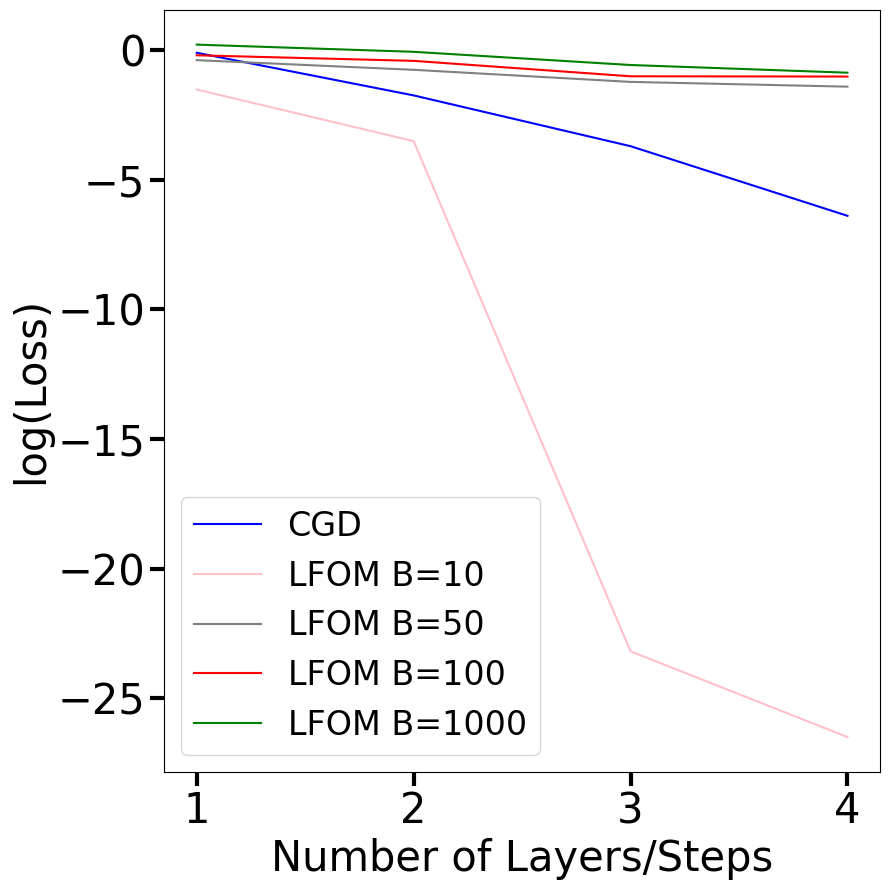

In [ ]:
####################################
# plot final test loss against N
####################################

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (9, 9))

plt.plot(n_layers, gd_loss_mean, color='blue', label='CGD')
plt.fill_between(n_layers, gd_loss_mean - gd_loss_std/10, gd_loss_mean + gd_loss_std/10, color='blue', alpha=0.2)

plt.plot(n_layers, gd_loss_meanB10, color='pink', label='LFOM B=10')
plt.fill_between(n_layers, gd_loss_meanB10 - gd_loss_stdB10/10, gd_loss_meanB10 + gd_loss_stdB10/10, color='blue', alpha=0.2)

plt.plot(n_layers, gd_loss_meanB50, color='grey', label='LFOM B=50')
plt.fill_between(n_layers, gd_loss_meanB50 - gd_loss_stdB50/10, gd_loss_meanB50 + gd_loss_stdB50/10, color='blue', alpha=0.2)

plt.plot(n_layers, gd_loss_meanB100, color='red', label='LFOM B=100')
plt.fill_between(n_layers, gd_loss_meanB100 - gd_loss_stdB100/10, gd_loss_meanB100 + gd_loss_stdB100/10, color='blue', alpha=0.2)

plt.plot(n_layers, gd_loss_meanB1000, color='green', label='LFOM B=1000')
plt.fill_between(n_layers, gd_loss_meanB1000 - gd_loss_stdB1000/10, gd_loss_meanB1000 + gd_loss_stdB1000/10, color='blue', alpha=0.2)

plt.ylabel('log(Loss)',fontsize=30)
plt.xlabel('Number of Layers/Steps',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
ax.legend(fontsize=24)
#ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/variable-L-plot.pdf', dpi=600)